# Sistemas de recomendación con LightFM
En este notebook se obtienen los distintos tipos de modelos (colaborativo, basado en contenido e híbrido) con el conjunto de datos de MovieLens y la librería LightFM.

In [18]:
# Importar todo lo necesario
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split

import multiprocessing

In [6]:
# Obtención del número de hilos del procesador
cpu_threads = multiprocessing.cpu_count()

## Recomendaciones

In [7]:
# Pequeña función para ver las recomendaciones
def sample_recommendation(model, data, user_ids, items_df):
    n_users, n_items = data.shape

    for user_id in user_ids:
        known_positives = items_df['Título'][data.tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = items_df['Título'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("    Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)
            
        print("    Recommended:")
        
        for x in top_items[:3]:
            print("         %s" % x)

In [8]:
# Pequeña función para ver las recomendaciones
def sample_recommendation_lastfm(model, data, user_ids, items_df):
    n_users, n_items = data.shape

    for user_id in user_ids:
        known_positives = items_df['Nombre'][data.tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = items_df['Nombre'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("    Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)
            
        print("    Recommended:")
        
        for x in top_items[:3]:
            print("         %s" % x)

In [9]:
# Pequeña función para ver las recomendaciones
def sample_recommendation_dating(model, data, user_ids, items_df):
    n_users, n_items = data.shape

    for user_id in user_ids:
        known_positives = items_df['Id Match'][data.tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = items_df['Id Match'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("    Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)
            
        print("    Recommended:")
        
        for x in top_items[:3]:
            print("         %s" % x)

## MovieLens

### Obtención de los dataframes

In [10]:
# Obtención del dataframe de datos
ml_data_df = pd.read_csv('data/movielens/ml_data.csv', delim_whitespace=True, names=['Id Usuario','Id Película','Valoración','Fecha'])
ml_data_df.sort_values(['Id Usuario', 'Id Película'], inplace=True)

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#ml_data_df

# Obtención del dataframe de usuarios
ml_users_df = pd.read_csv('data/movielens/user.csv', sep='|', names=['Id Usuario', 'Edad', 'Género', 'Ocupación', 'Código Postal'])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#ml_users_df

# Obtención del dataframe de items
ml_items_df = pd.read_csv('data/movielens/ml_items.csv', sep='|',
    names=['Id Película','Título','Fecha de estreno','Fecha DVD','iMDB','Género desconocido','Acción','Aventura','Animación','Infantil','Comedia', 'Crimen','Docuemntal','Drama','Fantasía','Cine negro','Horror','Musical','Misterio','Romance','Ciencia ficción','Thriller','Bélico','Western'],
    encoding='latin-1')

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#ml_items_df

### Obtención del dataset y de las matrices   
Convierto los dataframes en las estructuras de datos que necesita LightFM para poder sacar las matrices y poder hacer uso de su sistema de recomendación

In [11]:
# Obtención de los dataset
ml_dataset = Dataset()
ml_dataset.fit(ml_data_df['Id Usuario'], ml_data_df['Id Película'])
ml_dataset.fit_partial(users=ml_users_df['Id Usuario'], items=ml_items_df['Id Película'],
                    user_features=ml_users_df['Género'], item_features=ml_items_df['Título'])

# Obtención de las matrices
(ml_interactions, ml_weights) = ml_dataset.build_interactions((row['Id Usuario'], row['Id Película'], row['Valoración']) for index, row in ml_data_df.iterrows())
ml_item_features = ml_dataset.build_item_features((row['Id Película'], [row['Título']]) for index, row in ml_items_df.iterrows())
ml_user_features = ml_dataset.build_user_features((row['Id Usuario'], [row['Género']]) for index, row in ml_users_df.iterrows())

### División de los datos

In [12]:
ml_train, ml_test = random_train_test_split(ml_interactions, test_percentage=0.2)

### Obtención de los modelos

#### Modelo colaborativo

In [13]:
ml_collab_model = LightFM(loss='warp')
ml_collab_model.fit(ml_train, epochs=30, num_threads=cpu_threads)

In [14]:
"""
# Obtención de las predicciones para el primer usuario del conjunto de test

ml_user_test = ml_test.row[0]

# Obtención de un array con los ids de las películas
ml_list_predictions = list()
for i in range(1682):
    ml_list_predictions.append(i)
    
ml_array = np.asarray(ml_list_predictions)

ml_collab_predictions = ml_collab_model.predict_rank(ml_test, 
                                                     train_interactions=ml_train, 
                                                     num_threads=multiprocessing.cpu_count())


# Obtención de las predicciones del ml_user
ml_predictions = ml_collab_model.predict([ml_user_test], ml_array, num_threads=multiprocessing.cpu_count())

ml_predictions_dict = dict()
i = 0
for ml_prediction in ml_predictions:
    ml_predictions_dict[i] = ml_prediction
    i += 1
    
ml_predictions_df = pd.DataFrame.from_dict(ml_predictions_dict, orient='index', columns=['Score'])
ml_predictions_df.sort_values(['Score'], ascending=False, inplace=True)
print(ml_predictions_df)
"""

"\n# Obtención de las predicciones para el primer usuario del conjunto de test\n\nml_user_test = ml_test.row[0]\n\n# Obtención de un array con los ids de las películas\nml_list_predictions = list()\nfor i in range(1682):\n    ml_list_predictions.append(i)\n    \nml_array = np.asarray(ml_list_predictions)\n\nml_collab_predictions = ml_collab_model.predict_rank(ml_test, \n                                                     train_interactions=ml_train, \n                                                     num_threads=multiprocessing.cpu_count())\n\n\n# Obtención de las predicciones del ml_user\nml_predictions = ml_collab_model.predict([ml_user_test], ml_array, num_threads=multiprocessing.cpu_count())\n\nml_predictions_dict = dict()\ni = 0\nfor ml_prediction in ml_predictions:\n    ml_predictions_dict[i] = ml_prediction\n    i += 1\n    \nml_predictions_df = pd.DataFrame.from_dict(ml_predictions_dict, orient='index', columns=['Score'])\nml_predictions_df.sort_values(['Score'], ascending=

In [15]:
# Obtención de la precisión k con el modelo colaborativo
ml_collab_precision_at_k = precision_at_k(ml_collab_model, ml_test, 
                                          train_interactions=ml_train, k=10, num_threads=cpu_threads).mean()

In [20]:
# Obtención del AUC score con el modelo colaborativo
ml_collab_auc_score = auc_score(ml_collab_model, ml_test, train_interactions=ml_train, num_threads=cpu_threads).mean()

In [21]:
print('Precisión k: %.2f' % ml_collab_precision_at_k)
print('AUC score: %.2f' % ml_collab_auc_score)

Precisión k: 0.33
AUC score: 0.93


#### Modelo híbrido

In [22]:
ml_hybrid_model = LightFM(loss='warp')
ml_hybrid_model.fit(ml_train, item_features=ml_item_features, epochs=30, num_threads=cpu_threads)

In [23]:
ml_hybrid_predictions = ml_hybrid_model.predict_rank(ml_test, train_interactions=ml_train, 
                                                     item_features=ml_item_features,  
                                                     num_threads=multiprocessing.cpu_count())

In [24]:
#sample_recommendation(ml_hybrid_model, ml_interactions, [3, 25, 450], ml_items_df)

In [25]:
# Obtención de la precisión k con el modelo híbrido
ml_hybrid_precision_at_k = precision_at_k(ml_hybrid_model, ml_test, train_interactions=ml_train, 
                                          item_features=ml_item_features, k=10, num_threads=cpu_threads).mean()

In [26]:
# Obtención del AUC score con el modelo híbrido
ml_hybrid_auc_score = auc_score(ml_hybrid_model, ml_test, train_interactions=ml_train, 
                                item_features=ml_item_features, num_threads=cpu_threads).mean()

In [27]:
print('Precisión k: %.2f' % ml_hybrid_precision_at_k)
print('AUC score: %.2f' % ml_hybrid_auc_score)

Precisión k: 0.34
AUC score: 0.93


#### Modelo por contenido

In [28]:
ml_content_model = LightFM(loss='warp')
ml_content_model.fit(ml_train, user_features=ml_user_features, item_features=ml_item_features, 
                     epochs=30, num_threads=cpu_threads)

In [29]:
#sample_recommendation(ml_content_model, ml_interactions, [3, 25, 450], ml_items_df)

In [30]:
ml_content_predictions = ml_content_model.predict_rank(ml_test, train_interactions=ml_train, 
                                                       item_features=ml_item_features, 
                                                       user_features=ml_user_features, 
                                                       num_threads=cpu_threads)

In [31]:
# Obtención de la precisión k con el modelo por contenido
ml_content_precision_at_k = precision_at_k(ml_content_model, ml_test, train_interactions=ml_train, 
                                           user_features=ml_user_features, 
                                           item_features=ml_item_features, k=10, num_threads=cpu_threads).mean()

In [32]:
# Obtención del AUC score con el modelo por contenido
ml_content_auc_score = auc_score(ml_content_model, ml_test, train_interactions=ml_train, 
                                 user_features=ml_user_features, 
                                 item_features=ml_item_features, num_threads=cpu_threads).mean()

In [33]:
print('Precisión k: %.2f' % ml_content_precision_at_k)
print('AUC score: %.2f' % ml_content_auc_score)

Precisión k: 0.31
AUC score: 0.92


## Anime

### Obtención de los dataframes

In [34]:
# Obtención del dataframe de items
anime_items_df = pd.read_csv('data/anime/anime.csv', sep=',', 
    names=['Id Anime', 'Título', 'Género', 'Tipo', 'Episodios', 'Valoración Media', 'Miembros'])
anime_items_df.sort_values(['Id Anime'], inplace=True)

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#anime_items_df

# Obtención del dataframe de datos
anime_data1_df = pd.read_csv('data/anime/ratings1.csv', sep=',', names=['Id Usuario', 'Id Anime', 'Valoración'], low_memory=False)
anime_data2_df = pd.read_csv('data/anime/ratings2.csv', sep=',', names=['Id Usuario', 'Id Anime', 'Valoración'], low_memory=False)
anime_data3_df = pd.read_csv('data/anime/ratings3.csv', sep=',', names=['Id Usuario', 'Id Anime', 'Valoración'], low_memory=False)
anime_data4_df = pd.read_csv('data/anime/ratings4.csv', sep=',', names=['Id Usuario', 'Id Anime', 'Valoración'], low_memory=False)
anime_data_df = pd.concat([anime_data1_df, anime_data2_df, anime_data3_df, anime_data4_df])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#anime_data_df

### Obtención del dataset y de las matrices  
Convierto los dataframes en las estructuras de datos que necesita LightFM para poder sacar las matrices y poder hacer uso de su sistema de recomendación

In [35]:
# Obtención de los dataset
anime_dataset = Dataset()
anime_dataset.fit(anime_data_df['Id Usuario'], anime_data_df['Id Anime'])
anime_dataset.fit_partial(items=anime_items_df['Id Anime'], item_features=anime_items_df['Título'])

# Obtención de las matrices
(anime_interactions, anime_weights) = anime_dataset.build_interactions((row['Id Usuario'], row['Id Anime'], row['Valoración']) for index, row in anime_data_df.iterrows())
anime_item_features = anime_dataset.build_item_features((row['Id Anime'], [row['Título']]) for index, row in anime_items_df.iterrows())

### División de los datos

In [36]:
anime_train, anime_test = random_train_test_split(anime_interactions, test_percentage=0.2)

### Obtención de los modelos

#### Modelo colaborativo

In [37]:
anime_collab_model = LightFM(loss='warp')
anime_collab_model.fit(anime_train, epochs=30, num_threads=cpu_threads)

In [38]:
#sample_recommendation(anime_collab_model, anime_interactions, [3, 25, 450], anime_items_df)

In [27]:
anime_collab_predictions = anime_collab_model.predict_rank(anime_test, 
                                                           train_interactions=anime_train, 
                                                           num_threads=cpu_threads,
                                                           check_intersections=False)

In [40]:
# Obtención de la precisión k con el modelo colaborativo
anime_collab_precision_at_k = precision_at_k(anime_collab_model, anime_test, 
                                             train_interactions=anime_train, k=10, num_threads=cpu_threads, 
                                             check_intersections=False).mean()

In [41]:
# Obtención del AUC score con el modelo colaborativo
anime_collab_auc_score = auc_score(anime_collab_model, anime_test, 
                                   train_interactions=anime_train, num_threads=cpu_threads, check_intersections=False).mean()

In [42]:
print('Precisión k: %.2f' % anime_collab_precision_at_k)
print('AUC score: %.2f' % anime_collab_auc_score)

Precisión k: 0.26
AUC score: 0.98


#### Modelo híbrido

In [43]:
anime_hybrid_model = LightFM(loss='warp')
anime_hybrid_model.fit(anime_interactions, 
                       item_features=anime_item_features, 
                       epochs=30, num_threads=cpu_threads)

In [29]:
#sample_recommendation(anime_hybrid_model, anime_interactions, [3, 25, 450], anime_items_df)

In [30]:
anime_hybrid_predictions = anime_hybrid_model.predict_rank(anime_test, 
                                                           train_interactions=anime_train, 
                                                           item_features=anime_item_features, 
                                                           num_threads=cpu_threads,
                                                           check_intersections=False)

In [44]:
# Obtención de la precisión k con el modelo híbrido
anime_hybrid_precision_at_k = precision_at_k(anime_hybrid_model, anime_test, train_interactions=anime_train, 
                                             item_features=anime_item_features, k=10, num_threads=cpu_threads, 
                                             check_intersections=False).mean()

In [45]:
# Obtención del AUC score con el modelo híbrido
anime_hybrid_auc_score = auc_score(anime_hybrid_model, anime_test, train_interactions=anime_train, 
                                item_features=anime_item_features, num_threads=cpu_threads, check_intersections=False).mean()

In [46]:
print('Precisión k: %.2f' % anime_hybrid_precision_at_k)
print('AUC score: %.2f' % anime_hybrid_auc_score)

Precisión k: 0.28
AUC score: 0.98


## Book-Crossing

### Obtención de los dataframes

In [47]:
# Obtención del dataframe de datos
bc_data_df = pd.read_csv('data/book-crossing/BX-Book-Ratings.csv', sep=';', names=['Id Usuario','ISBN','Valoración'], encoding='cp1252', low_memory=False)
bc_data_df.sort_values(['Id Usuario'], inplace=True)

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#bc_data_df

# Obtención del dataframe de usuarios
bc_users_df = pd.read_csv('data/book-crossing/BX-Users.csv', sep=';', names=['Id Usuario', 'Residencia', 'Edad'], encoding='cp1252')
bc_users_df = bc_users_df.fillna(0)

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#bc_users_df

# Obtención del dataframe de items
bc_items_df = pd.read_csv('data/book-crossing/BX-Books.csv', sep=';', names=['ISBN','Título','Autor','Fecha de publicación','Editorial','URL S','URL M','URL L'], encoding='cp1252', low_memory=False)

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#bc_items_df

### Obtención del dataset y de las matrices  
Convierto los dataframes en las estructuras de datos que necesita LightFM para poder sacar las matrices y poder hacer uso de su sistema de recomendación

In [48]:
# Obtención de los dataset
bc_dataset = Dataset()
bc_dataset.fit(bc_data_df['Id Usuario'], bc_data_df['ISBN'])
bc_dataset.fit_partial(users=bc_users_df['Id Usuario'], items=bc_items_df['ISBN'],
                    user_features=bc_users_df['Edad'], item_features=bc_items_df['Título'])

#num_users, num_items = bc_dataset.interactions_shape()
#print('Num users: {}, num_items {}.'.format(num_users, num_items))

# Obtención de las matrices
(bc_interactions, bc_weights) = bc_dataset.build_interactions((row['Id Usuario'], row['ISBN'], row['Valoración']) for index, row in bc_data_df.iterrows())
bc_item_features = bc_dataset.build_item_features((row['ISBN'], [row['Título']]) for index, row in bc_items_df.iterrows())
bc_user_features = bc_dataset.build_user_features((row['Id Usuario'], [row['Edad']]) for index, row in bc_users_df.iterrows())

### División de los datos

In [49]:
bc_train, bc_test = random_train_test_split(bc_interactions, test_percentage=0.2)

### Obtención de los modelos

#### Modelo colaborativo

In [50]:
bc_collab_model = LightFM(loss='warp')
bc_collab_model.fit(bc_train, epochs=30, num_threads=cpu_threads)

In [35]:
#sample_recommendation(bc_collab_model, bc_interactions, [3, 25, 450], bc_items_df)

In [39]:
bc_collab_predictions = bc_collab_model.predict_rank(bc_test, 
                                                     train_interactions=bc_train, 
                                                     num_threads=cpu_threads)

In [51]:
# Obtención de la precisión k con el modelo colaborativo
bc_collab_precision_at_k = precision_at_k(bc_collab_model, bc_test, 
                                          train_interactions=bc_train, k=10, num_threads=cpu_threads).mean()

In [52]:
# Obtención del AUC score con el modelo colaborativo
bc_collab_auc_score = auc_score(bc_collab_model, bc_test, 
                                train_interactions=bc_train, num_threads=cpu_threads).mean()

In [53]:
print('Precisión k: %.2f' % bc_collab_precision_at_k)
print('AUC score: %.2f' % bc_collab_auc_score)

Precisión k: 0.00
AUC score: 0.75


#### Modelo híbrido

In [54]:
bc_hybrid_model = LightFM(loss='warp')
bc_hybrid_model.fit(bc_train, 
                    item_features=bc_item_features, 
                    epochs=30, num_threads=cpu_threads)

In [41]:
#sample_recommendation(bc_hybrid_model, bc_interactions, [3, 25, 450], bc_items_df)

In [42]:
bc_hybrid_predictions = bc_hybrid_model.predict_rank(bc_test, 
                                                     train_interactions=bc_train, 
                                                     item_features=bc_item_features, 
                                                     num_threads=cpu_threads)

In [55]:
# Obtención de la precisión k con el modelo híbrido
bc_hybrid_precision_at_k = precision_at_k(bc_hybrid_model, bc_test, train_interactions=bc_train, 
                                          item_features=bc_item_features, k=10, num_threads=cpu_threads).mean()

In [56]:
# Obtención del AUC score con el modelo híbrido
bc_hybrid_auc_score = auc_score(bc_hybrid_model, bc_test, train_interactions=bc_train, 
                                item_features=bc_item_features, num_threads=cpu_threads).mean()

In [57]:
print('Precisión k: %.2f' % bc_hybrid_precision_at_k)
print('AUC score: %.2f' % bc_hybrid_auc_score)

Precisión k: 0.00
AUC score: 0.76


#### Modelo por contenido

In [58]:
bc_content_model = LightFM(loss='warp')
bc_content_model.fit(bc_train, 
                     user_features=bc_user_features, 
                     item_features=bc_item_features, 
                     epochs=30, num_threads=cpu_threads)

In [44]:
#sample_recommendation(bc_content_model, bc_interactions, [3, 25, 450], bc_items_df)

In [45]:
bc_content_predictions = bc_content_model.predict_rank(bc_test, train_interactions=bc_train, 
                                                       item_features=bc_item_features, 
                                                       user_features=bc_user_features, 
                                                       num_threads=cpu_threads)

In [59]:
# Obtención de la precisión k con el modelo por contenido
bc_content_precision_at_k = precision_at_k(bc_content_model, bc_test, train_interactions=bc_train, 
                                           user_features=bc_user_features,
                                           item_features=bc_item_features, k=10, num_threads=cpu_threads).mean()

In [60]:
# Obtención del AUC score con el modelo por contenido
bc_content_auc_score = auc_score(bc_content_model, bc_test, train_interactions=bc_train, 
                                 user_features=bc_user_features,
                                 item_features=bc_item_features, num_threads=cpu_threads).mean()

In [61]:
print('Precisión k: %.2f' % bc_content_precision_at_k)
print('AUC score: %.2f' % bc_content_auc_score)

Precisión k: 0.00
AUC score: 0.72


## LastFM

### Obtención de los dataframes

In [62]:
# Obtención del dataframe de datos
lf_data_df = pd.read_csv('data/lastfm/user_artists.csv', sep='\t', names=['Id Usuario','Id Artista','Veces escuchado'])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#lf_data_df

# Obtención del dataframe de usuarios
lf_users_df = pd.read_csv('data/lastfm/user_friends.csv', sep='\t', names=['Id Usuario', 'Id Amigo'])

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#lf_users_df

# Obtención del dataframe de items
lf_artists_df = pd.read_csv('data/lastfm/artists.csv', sep='\t', names=['Id Artista','Nombre','URL','URL Foto'])
lf_artists_df = lf_artists_df.drop(['URL', 'URL Foto'], axis=1)
lf_generos_df = pd.read_csv('data/lastfm/user_taggedartists-timestamps.csv', sep='\t', names=['Id Usuario','Id Artista','Id Genero','Timestamp'])
lf_generos_df = lf_generos_df.drop(['Id Usuario', 'Timestamp'], axis=1)
lf_items_df = lf_artists_df.merge(lf_generos_df, left_on='Id Artista', right_on='Id Artista') 

# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#lf_items_df

### Obtención del dataset y de las matrices

In [63]:
# Obtención de los dataset
lf_dataset = Dataset()
lf_dataset.fit(lf_data_df['Id Usuario'], lf_data_df['Id Artista'])
lf_dataset.fit_partial(users=lf_users_df['Id Usuario'], items=lf_items_df['Id Artista'],
                    user_features=lf_users_df['Id Amigo'], item_features=lf_items_df['Nombre'])

# Obtención de las matrices
(lf_interactions, lf_weights) = lf_dataset.build_interactions((row['Id Usuario'], row['Id Artista'], row['Veces escuchado']) for index, row in lf_data_df.iterrows())
lf_item_features = lf_dataset.build_item_features((row['Id Artista'], [row['Nombre']]) for index, row in lf_items_df.iterrows())
lf_user_features = lf_dataset.build_user_features((row['Id Usuario'], [row['Id Amigo']]) for index, row in lf_users_df.iterrows())

### División de los datos

In [64]:
lf_train, lf_test = random_train_test_split(lf_interactions, test_percentage=0.2)

### Obtención de los modelos

#### Modelo colaborativo

In [65]:
lf_collab_model = LightFM(loss='warp')
lf_collab_model.fit(lf_train, epochs=30, num_threads=cpu_threads)

In [50]:
#sample_recommendation_lastfm(lf_collab_model, lf_interactions, [3, 25, 450], lf_items_df)

In [51]:
lf_collab_predictions = lf_collab_model.predict_rank(lf_test, 
                                                     train_interactions=lf_train, 
                                                     num_threads=cpu_threads)

In [66]:
# Obtención de la precisión k con el modelo colaborativo
lf_collab_precision_at_k = precision_at_k(lf_collab_model, lf_test, 
                                          train_interactions=lf_train, k=10, num_threads=cpu_threads).mean()

In [67]:
# Obtención del AUC score con el modelo colaborativo
lf_collab_auc_score = auc_score(lf_collab_model, lf_test, 
                                train_interactions=lf_train, num_threads=cpu_threads).mean()

In [68]:
print('Precisión k: %.2f' % lf_collab_precision_at_k)
print('AUC score: %.2f' % lf_collab_auc_score)

Precisión k: 0.14
AUC score: 0.87


#### Modelo híbrido

In [69]:
lf_hybrid_model = LightFM(loss='warp')
lf_hybrid_model.fit(lf_train, item_features=lf_item_features, epochs=30, num_threads=cpu_threads)

In [53]:
#sample_recommendation_lastfm(lf_hybrid_model, lf_interactions, [3, 25, 450], lf_items_df)

In [55]:
lf_hybrid_predictions = lf_hybrid_model.predict_rank(lf_test,
                                                    train_interactions=lf_train,
                                                    item_features=lf_item_features,
                                                    num_threads=multiprocessing.cpu_count())

In [70]:
# Obtención de la precisión k con el modelo híbrido
lf_hybrid_precision_at_k = precision_at_k(lf_hybrid_model, lf_test, train_interactions=lf_train, 
                                          item_features=lf_item_features, k=10, num_threads=cpu_threads).mean()

In [71]:
# Obtención del AUC score con el modelo híbrido
lf_hybrid_auc_score = auc_score(lf_hybrid_model, lf_test, train_interactions=lf_train, 
                                item_features=lf_item_features, num_threads=cpu_threads).mean()

In [72]:
print('Precisión k: %.2f' % lf_hybrid_precision_at_k)
print('AUC score: %.2f' % lf_hybrid_auc_score)

Precisión k: 0.14
AUC score: 0.87


#### Modelo por contenido

In [73]:
lf_content_model = LightFM(loss='warp')
lf_content_model.fit(lf_train, 
                     user_features=lf_user_features, 
                     item_features=lf_item_features, 
                     epochs=30, num_threads=cpu_threads)

In [57]:
#sample_recommendation_lastfm(lf_content_model, lf_interactions, [3, 25, 450], lf_items_df)

In [58]:
lf_content_predictions = lf_content_model.predict_rank(lf_test, train_interactions=lf_train, 
                                                       item_features=lf_item_features, 
                                                       user_features=lf_user_features, 
                                                       num_threads=cpu_threads)

In [74]:
# Obtención de la precisión k con el modelo por contenido
lf_content_precision_at_k = precision_at_k(lf_content_model, lf_test, train_interactions=lf_train, 
                                           user_features=lf_user_features,
                                           item_features=lf_item_features, k=10, num_threads=cpu_threads).mean()

In [75]:
# Obtención del AUC score con el modelo por contenido
lf_content_auc_score = auc_score(lf_content_model, lf_test, train_interactions=lf_train, 
                                 user_features=lf_user_features,
                                 item_features=lf_item_features, num_threads=cpu_threads).mean()

In [76]:
print('Precisión k: %.2f' % lf_content_precision_at_k)
print('AUC score: %.2f' % lf_content_auc_score)

Precisión k: 0.13
AUC score: 0.86


## Dating Agency

### Obtención de los dataframes

In [77]:
# Obtención del dataframe de datos
dating_data_df = pd.read_csv(r'C:\Users\Raúl\Downloads\Datasets TFG\Dating Agency\ratings.csv', sep=',', 
                             names=['Id Usuario', 'Id Match', 'Valoración'], engine='python')
# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#dating_data_df

# Obtención del dataframe de usuarios/items
dating_users_df = pd.read_csv(r'C:\Users\Raúl\Downloads\Datasets TFG\Dating Agency\gender.csv', sep=',', 
                              names=['Id Usuario', 'Género'], engine='python')
# Descomentar para comprobar que el dataframe se ha obtenido correctamente
#dating_users_df

### Obtención del dataset y de las matrices

In [78]:
# Obtención de los dataset
dating_dataset = Dataset()
dating_dataset.fit(dating_data_df['Id Usuario'], dating_data_df['Id Match'])
dating_dataset.fit_partial(users=dating_users_df['Id Usuario'], items=dating_users_df['Id Usuario'],
                    user_features=dating_users_df['Género'], item_features=dating_users_df['Género'])

# Obtención de las matrices
(dating_interactions, dating_weights) = dating_dataset.build_interactions((row['Id Usuario'], row['Id Match'], row['Valoración']) for index, row in dating_data_df.iterrows())
dating_item_features = dating_dataset.build_item_features((row['Id Usuario'], [row['Género']]) for index, row in dating_users_df.iterrows())
dating_user_features = dating_dataset.build_user_features((row['Id Usuario'], [row['Género']]) for index, row in dating_users_df.iterrows())

### División de los datos

In [80]:
dating_train, dating_test = random_train_test_split(dating_interactions, test_percentage=0.2)

### Obtención de los modelos

#### Modelo colaborativo

In [ ]:
dating_collab_model = LightFM(loss='warp')
dating_collab_model.fit(dating_train, epochs=30, num_threads=cpu_threads)

In [63]:
#sample_recommendation_dating(dating_collab_model, dating_interactions, [3, 25, 450], dating_data_df)

In [64]:
dating_collab_predictions = dating_collab_model.predict_rank(dating_test, 
                                                             train_interactions=dating_train, 
                                                             num_threads=cpu_threads)

In [ ]:
# Obtención de la precisión k con el modelo colaborativo
dating_collab_precision_at_k = precision_at_k(dating_collab_model, dating_test, 
                                              train_interactions=dating_train, k=10, num_threads=cpu_threads).mean()

In [ ]:
# Obtención del AUC score con el modelo colaborativo
dating_collab_auc_score = auc_score(dating_collab_model, dating_test, 
                                    train_interactions=dating_train, num_threads=cpu_threads).mean()

In [ ]:
print('Precisión k: %.2f' % dating_collab_precision_at_k)
print('AUC score: %.2f' % dating_collab_auc_score)

#### Modelo híbrido

In [ ]:
dating_hybrid_model = LightFM(loss='warp')
dating_hybrid_model.fit(dating_train, item_features=dating_item_features, epochs=30, num_threads=cpu_threads)

In [ ]:
#sample_recommendation_dating(dating_hybrid_model, dating_interactions, [3, 25, 450], dating_data_df)

In [ ]:
dating_hybrid_predictions = dating_hybrid_model.predict_rank(dating_test, 
                                                             train_interactions=dating_train, 
                                                             item_features=dating_item_features, 
                                                             num_threads=cpu_threads)

In [ ]:
# Obtención de la precisión k con el modelo híbrido
dating_hybrid_precision_at_k = precision_at_k(dating_hybrid_model, dating_test, train_interactions=dating_train, 
                                              item_features=dating_item_features, k=10, num_threads=cpu_threads).mean()

In [ ]:
# Obtención del AUC score con el modelo híbrido
dating_hybrid_auc_score = auc_score(dating_hybrid_model, dating_test, train_interactions=dating_train, 
                                    item_features=dating_item_features, num_threads=cpu_threads).mean()

In [ ]:
print('Precisión k: %.2f' % dating_hybrid_precision_at_k)
print('AUC score: %.2f' % dating_hybrid_auc_score)

#### Modelo por contenido

In [ ]:
dating_content_model = LightFM(loss='warp')
dating_content_model.fit(dating_train, 
                         user_features=dating_user_features, 
                         item_features=dating_item_features, 
                         epochs=30, num_threads=cpu_threads)

In [ ]:
#sample_recommendation_dating(dating_content_model, dating_interactions, [3, 25, 450], dating_data_df)

In [ ]:
dating_content_predictions = dating_content_model.predict_rank(dating_test, 
                                                               train_interactions=dating_train, 
                                                               item_features=dating_item_features, 
                                                               user_features=dating_user_features, 
                                                               num_threads=cpu_threads)

In [ ]:
# Obtención de la precisión k con el modelo por contenido
dating_content_precision_at_k = precision_at_k(dating_content_model, dating_test, train_interactions=dating_train, 
                                               user_features=dating_user_features, 
                                               item_features=dating_item_features, k=10, num_threads=cpu_threads).mean()

In [ ]:
# Obtención del AUC score con el modelo por contenido
dating_content_auc_score = auc_score(dating_content_model, dating_test, train_interactions=dating_train, 
                                     user_features=dating_user_features, 
                                     item_features=dating_item_features, num_threads=cpu_threads).mean()

In [ ]:
print('Precisión k: %.2f' % dating_content_precision_at_k)
print('AUC score: %.2f' % dating_content_auc_score)

## Visualización de los conjuntos de datos

### Obtención de los tados

In [18]:
n_users_ml = len(ml_data_df['Id Usuario'].unique())
n_items_ml = len(ml_data_df['Id Película'].unique())
n_ratings_ml = ml_data_df['Valoración'].count()
ratings_per_user_ml = round(n_ratings_ml / n_users_ml)

n_users_anime = len(anime_data_df['Id Usuario'].unique())
n_items_anime = len(anime_data_df['Id Anime'].unique())
n_ratings_anime = anime_data_df['Valoración'].count()
ratings_per_user_anime = round(n_ratings_anime / n_users_anime)

n_users_bc = len(bc_data_df['Id Usuario'].unique())
n_items_bc = len(bc_data_df['ISBN'].unique())
n_ratings_bc = bc_data_df['Valoración'].count()
ratings_per_user_bc = round(n_ratings_bc / n_users_bc)

n_users_lf = len(lf_data_df['Id Usuario'].unique())
n_items_lf = len(lf_data_df['Id Artista'].unique())
n_ratings_lf = lf_data_df['Veces escuchado'].count()
ratings_per_user_lf = round(n_ratings_lf / n_users_lf)

n_users_dating = len(dating_data_df['Id Usuario'].unique())
n_items_dating = len(dating_data_df['Id Match'].unique())
n_ratings_dating = dating_data_df['Valoración'].count()
ratings_per_user_dating = round(n_ratings_dating / n_users_dating)

users = [n_users_ml, n_users_anime, n_users_bc, n_users_lf, n_users_dating]
items = [n_items_ml, n_items_anime, n_items_bc, n_items_lf, n_items_dating]
ratings = [ratings_per_user_ml, ratings_per_user_anime, ratings_per_user_bc, ratings_per_user_lf, ratings_per_user_dating]

### Obtención de los gráficos

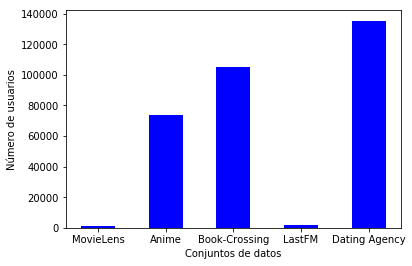

In [19]:
X = np.arange(5)
plt.bar(X, users, color="b", width=0.50)
plt.xticks(X, ["MovieLens", "Anime", "Book-Crossing", "LastFM", "Dating Agency"])
plt.xlabel("Conjuntos de datos")
plt.ylabel("Número de usuarios")
plt.show()

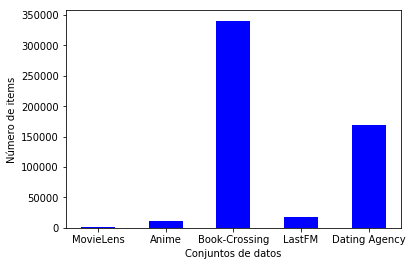

In [20]:
plt.bar(X, items, color="b", width=0.50)
plt.xticks(X, ["MovieLens", "Anime", "Book-Crossing", "LastFM", "Dating Agency"])
plt.xlabel("Conjuntos de datos")
plt.ylabel("Número de items")
plt.show()

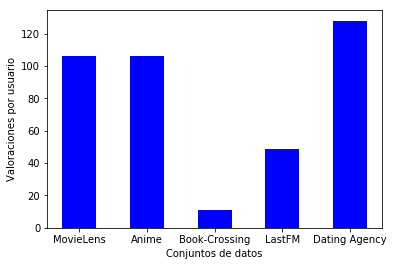

In [21]:
plt.bar(X, ratings, color="b", width=0.50)
plt.xticks(X, ["MovieLens", "Anime", "Book-Crossing", "LastFM", "Dating Agency"])
plt.xlabel("Conjuntos de datos")
plt.ylabel("Valoraciones por usuario")
plt.show()

In [29]:
graficos_df = pd.DataFrame({'Número de usuarios':users, 'Número de items':items, 'Valoraciones por usuario':ratings},
                          index=['MovieLens', 'Anime', 'Book-Crossing', 'LastFM', 'Dating Agency'])

grafica = graficos_df.plot.bar(rot=0, subplots=True)
grafica

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D00324C4A8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000002D00329C780>], dtype=object)